In [7]:
import pandas as ad
import os 
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt


In [8]:
paths = ["D:/fin_de_etude/data/subset0","D:/fin_de_etude/data/subset1","D:/fin_de_etude/data/subset2",
         "D:/fin_de_etude/data/subset3","D:/fin_de_etude/data/subset4","D:/fin_de_etude/data/subset5",
         "D:/fin_de_etude/data/subset6","D:/fin_de_etude/data/subset7","D:/fin_de_etude/data/subset8",
         "D:/fin_de_etude/data/subset9"]

df = ad.read_csv("D:/fin_de_etude/data/annotations.csv")
j = 1
for path in paths:
        for  file in os.listdir(path):
            if file.endswith(".mhd"):
                if file[:-4] in df["seriesuid"].tolist():
                    image = sitk.ReadImage(os.path.join(path, file))
                    df_2 = df[df["seriesuid"] == file[:-4]]
                    
                    
                    for index in df_2.index:
                       
                        x, y, z, d = df_2["coordX"][index], df_2["coordY"][index], df_2["coordZ"][index], df_2["diameter_mm"][index]
                 
                        point = (x, y, z) #  coordinates qui existe dans le fichier annotation
                        point_idx = image.TransformPhysicalPointToContinuousIndex(point) # transformer les coordinnaies de les données physique real a mond reél à des donnees presentable dans l'image
                        pixel_size = image.GetSpacing()[0]
                        
                        image_diameter = d/pixel_size
                       
                     
                        df.loc[index,"coordX"] = point_idx[0]
                        df.loc[index,"coordY"] = point_idx[1]
                        df.loc[index,"coordZ"] = int(point_idx[2])
                        df.loc[index,"diameter_mm"]= image_diameter
            
df.to_csv("annotation.csv",index=False)



In [9]:



def denoising(img):
    # Use MedianImageFilter instead of BilateralImageFilter
    median_filter = sitk.MedianImageFilter()
    denoised_image = median_filter.Execute(img)
    return denoised_image
    

In [10]:
def windowing(img):
    window_level = -600
    window_width = 1500

    # Apply the windowing filter
    window_filter = sitk.IntensityWindowingImageFilter()
    window_filter.SetWindowMinimum(window_level - window_width/2.0)
    window_filter.SetWindowMaximum(window_level + window_width/2.0)
    window_filter.SetOutputMinimum(0)
    window_filter.SetOutputMaximum(255)
    image_windowed = window_filter.Execute(img)
    return image_windowed

In [11]:
def get_2ddataset(paths):
    df = ad.read_csv("annotation.csv")
    j = 0
    df = df.sort_values("seriesuid")

    for path in paths:
        for file in os.listdir(path):
            if file.endswith(".mhd"):
                seriesuid = file[:-4]
                if seriesuid in df["seriesuid"].tolist():
                    j += 1  # Increment j only when the seriesuid exists in the DataFrame
                    image = sitk.ReadImage(os.path.join(path, file))
                    image = denoising(image)
                    image = windowing(image)
                    df_2 = df[df["seriesuid"] == seriesuid]
                    df_2 = df_2.sort_values(by="coordZ",ascending=False)
                    index = df_2.index
                    slice = 0
                    for i in index:
                            if i == index[0] or np.abs(int( df_2.loc[i, "coordZ"]) -int(slice))>1 or k>=1:
                            
                                slice_index = int(df_2.loc[i, "coordZ"])
                                
                                
                                arr_2d = image[:,:,slice_index]
                                sitk.WriteImage(arr_2d,os.path.join("D:/fin_de_etude/data/dataset_2d/nodule/", f"{j}.{slice_index}.mhd"))
                                df.loc[i, "seriesuid"] = f"{j}.{slice_index}"
                                k=0
                            else:
                                k+=1
                            df.loc[i, "seriesuid"] = f"{j}.{slice_index}"
                            slice = df_2.loc[i, "coordZ"]
                            
                else:
                    j += 1  # Increment j when the seriesuid does not exist in the DataFrame
                    image = sitk.ReadImage(os.path.join(path, file))
                    image = denoising(image)
                    image = windowing(image)
                    size = image.GetSize()
                    arr_2d = image[:,:,size[2]//2]
                    sitk.WriteImage(arr_2d,os.path.join("D:/fin_de_etude/data/dataset_2d/nonnodule/", f"{j}.mhd"))
    df.to_csv("annotation_2.csv", index=False)


In [12]:
paths = ["D:/fin_de_etude/data/subset0","D:/fin_de_etude/data/subset1","D:/fin_de_etude/data/subset2",
         "D:/fin_de_etude/data/subset3","D:/fin_de_etude/data/subset4","D:/fin_de_etude/data/subset5",
         "D:/fin_de_etude/data/subset6","D:/fin_de_etude/data/subset7","D:/fin_de_etude/data/subset8",
         "D:/fin_de_etude/data/subset9"]
get_2ddataset(paths)

In [13]:
df = ad.read_csv("annotation_2.csv")
images = os.listdir("D:/fin_de_etude/data/dataset_2d/nodule/")
print(len(df["seriesuid"].unique()))
print(len(images)/2)
images = images[:40]

1153
1153.0


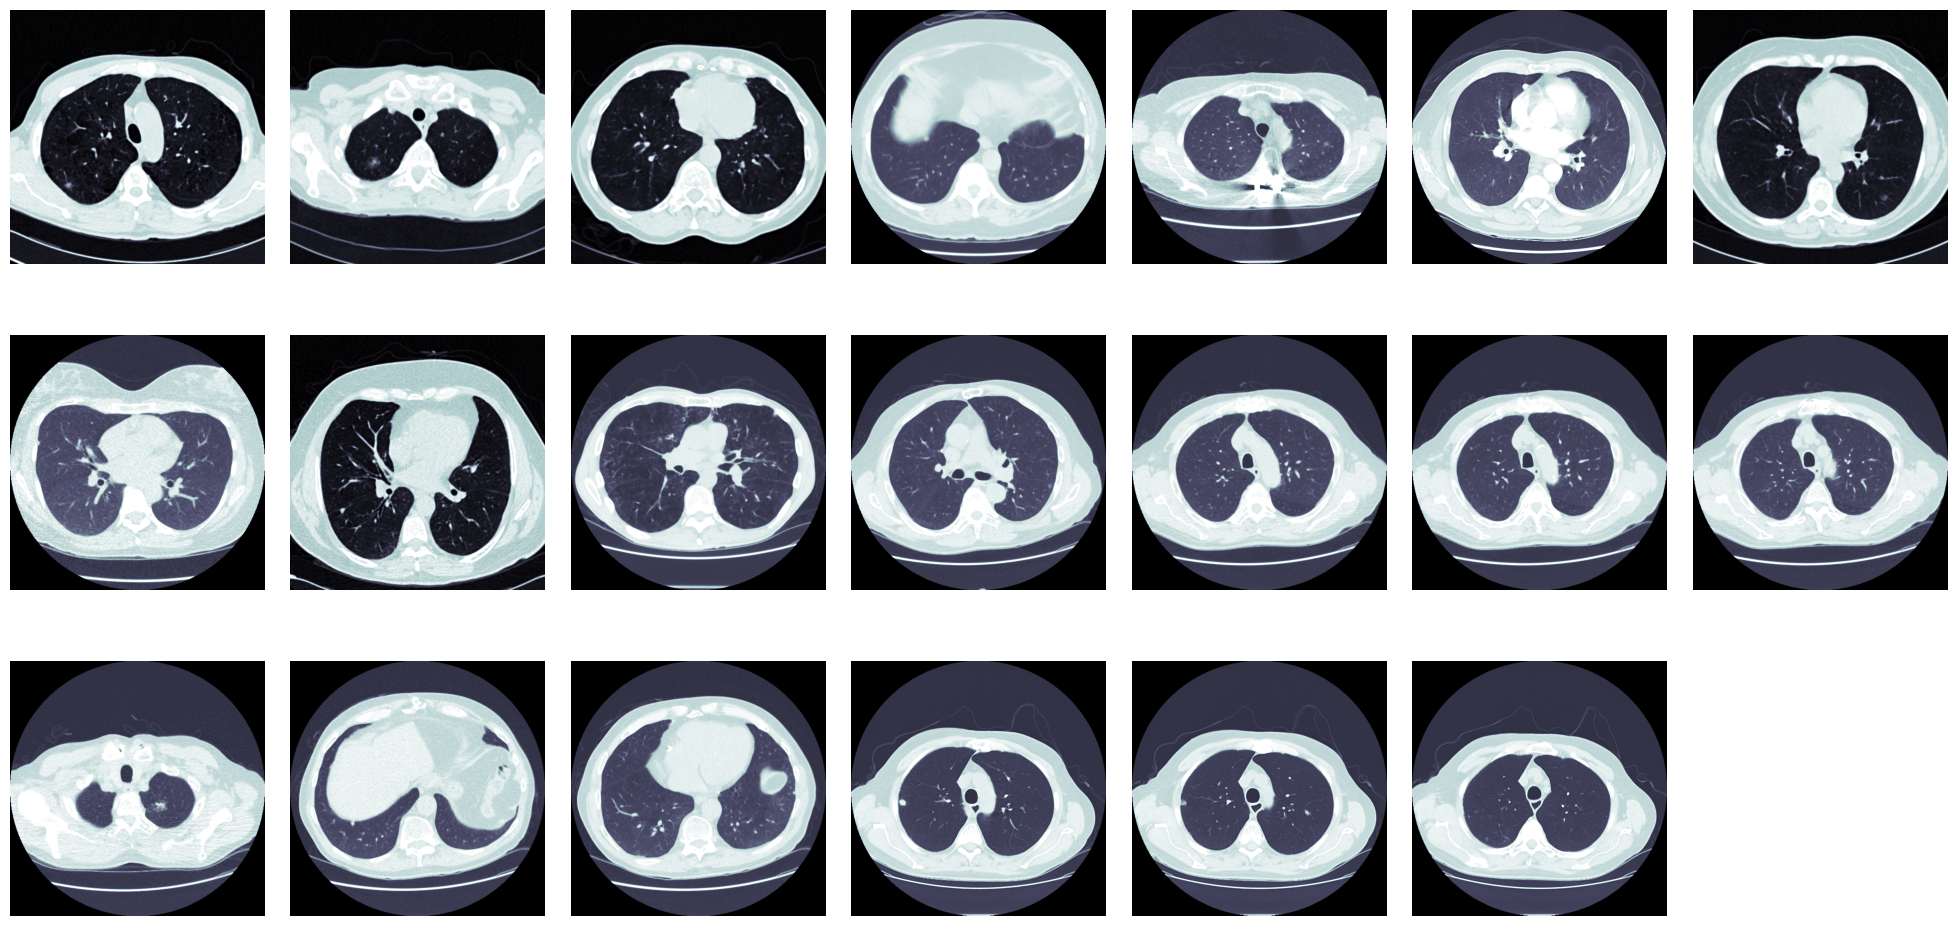

In [18]:
n_samples=len(images)
num_cols = int(np.ceil(np.sqrt(n_samples)))
num_rows = int(np.ceil(n_samples / num_cols))
fig = plt.figure(figsize=(25, 25))
i = 0
for file in images:
    if file.endswith(".mhd"):
        img = sitk.ReadImage(os.path.join("D:/fin_de_etude/data/dataset_2d/nodule/",file))
        img= sitk.GetArrayFromImage(img)
        axs =   fig.add_subplot(
                                        num_rows, num_cols,  1+i)
        axs.axis('off')
        axs.imshow(img,cmap=plt.cm.bone)
            
                
        i+=1
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # Show the plot
plt.show()


In [19]:
image_gray = sitk.ReadImage("D:/fin_de_etude/data/dataset_2d/nodule/10.370.mhd")
image_gray = sitk.GetArrayFromImage(image_gray)

1
117.01809548962024 354.126498041519 370.0


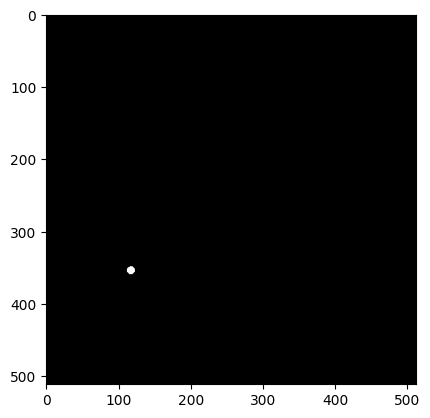

In [20]:
df = ad.read_csv("annotation_2.csv")
df = df[df["seriesuid"]==10.370]
print(len(df))
mask = np.zeros(image_gray.shape)
for i in df.index:
    x, y,z, d =float( df["coordX"][i]), float(df["coordY"][i]),float(df["coordZ"][i]), float(df["diameter_mm"][i])
    xx, yy = np.meshgrid(np.arange(image_gray.shape[0]), np.arange(image_gray.shape[1]))
    print(x,y,z)
 
    dist = np.sqrt((xx - x) ** 2 + (yy - y) ** 2 )
    mask[dist <= d / 2] = 1
plt.imshow(mask,cmap="gray")

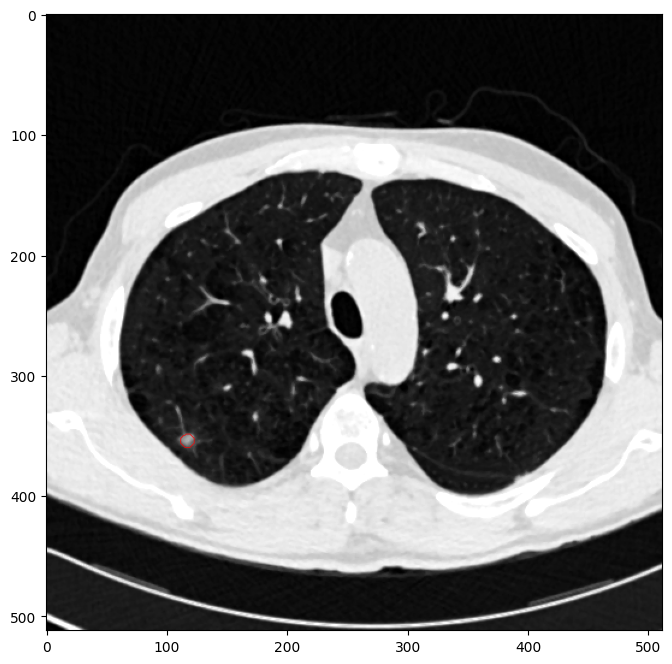

In [21]:
fig,ax1  = plt.subplots(ncols=1, figsize=(8, 8))
ax1.imshow(image_gray,cmap="gray" )

ax1.contour(mask, levels=[0.4], colors='r', linewidths=0.5)

plt.show()